In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from model import Create_transfert_learning_Model
from processing.generator import Dataset_Generator
from processing.processor import Image_Processing

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-11-22 18:38:39.640618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 18:38:39.683655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 18:38:39.683902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 18:38:39.684760: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

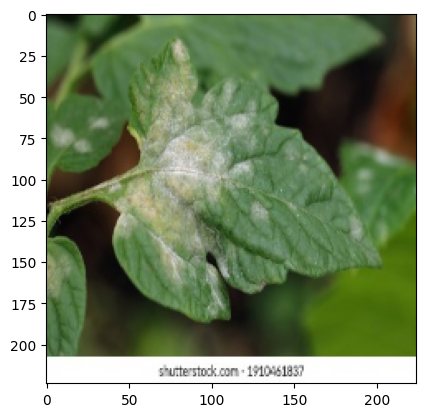

In [2]:
Processor = Image_Processing()
img = Processor("leaves_img/malade/fungal-plant-disease-powdery-mildew-260nw-1910461837.jpg")
plt.imshow(img)

In [3]:
Generator = Dataset_Generator(nbr_augmentation=1)

In [4]:
X_train, Y_train,\
X_dev, Y_dev,\
X_test, Y_test = Generator(healthy_dir_name='leaves_img/sain',
                           disease_dir_name='leaves_img/malade')

100%|██████████| 118/118 [00:02<00:00, 54.77it/s]


(1485, 224, 224, 3) (1485, 1)
(40, 224, 224, 3) (40, 1)
(120, 224, 224, 3) (120, 1)


In [5]:
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy 

model = Create_transfert_learning_Model(2)

In [6]:
history = model.fit(X_train, Y_train, epochs=15, batch_size=1, verbose=1, shuffle=True)

Epoch 1/15


2022-11-22 18:38:51.143669: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8600
2022-11-22 18:38:52.080372: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 477.70MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-22 18:38:52.080473: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 477.70MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-22 18:38:52.096753: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more me

   7/1485 [..............................] - ETA: 38s - loss: 0.3550 - accuracy: 0.4286  

2022-11-22 18:38:52.297546: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1485/1485 [==============================] - 42s 26ms/step - loss: 0.5027 - accuracy: 0.5030
Epoch 2/15
1485/1485 [==============================] - 38s 26ms/step - loss: 0.5024 - accuracy: 0.5024
Epoch 3/15
1485/1485 [==============================] - 38s 26ms/step - loss: 0.5024 - accuracy: 0.5024
Epoch 4/15
1485/1485 [==============================] - 40s 27ms/step - loss: 0.5024 - accuracy: 0.5024
Epoch 5/15
 159/1485 [==>...........................] - ETA: 35s - loss: 0.4465 - accuracy: 0.4465

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].plot(history.history['loss'])
ax[0].set_title("Loss after epochs")
ax[0].set_xlabel('Loss')
ax[0].set_ylabel('Epochs')

ax[1].plot(history.history['accuracy'])
ax[1].set_title("accuracy after epochs")
ax[1].set_xlabel('accuracy')
ax[1].set_ylabel('Epochs')

plt.show()